In [1]:
"""All required modules"""
!pip install torch-geometric
!pip install hiddenlayer
import hiddenlayer as hl
from numpy import loadtxt
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import joblib
import time
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'torchviz'

In [2]:
#installing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#positions = np.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions.txt') #load datasets
winners = pd.read_csv("/content/drive/MyDrive/My_stratego_project/files/Y_winners_encoded.csv", header = None)
positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions.txt')
positions = np.array(positions).reshape(99132, 40, 12) #Reshaping the data to a 40 by 12 matrix

In [4]:
"""for -1 to 1 classification, changes winner variable to -1 and 1, comment out to use 0/1 classification"""
winners_new = []
i=0
for winner in winners[0]:
  if winner == 0:
    winners_new.append(winner-1)
  else:
    winners_new.append(winner)
  i+=1

In [5]:
"""Creates 4 edge indeces based on the sizes created after the sagpooling operation, they're all square boards"""

##Possible imporvement to be added is to create edge index based on removed and included nodes after the sagpooling operation
def edge_index(row,column):
  """Creates a edge index based on a number of rows and columns as input"""
  edge_index = []
  for row in range(num_rows):
      for col in range(num_cols):
          node_idx = row * num_cols + col

          if row > 0:  #connect to top neighbor
              top_neighbor_idx = (row - 1) * num_cols + col
              edge_index.append([node_idx, top_neighbor_idx])

          if row < num_rows - 1:  #connect to bottom neighbor
              bottom_neighbor_idx = (row + 1) * num_cols + col
              edge_index.append([node_idx, bottom_neighbor_idx])

          if col > 0:  #connect to left neighbor
              left_neighbor_idx = row * num_cols + (col - 1)
              edge_index.append([node_idx, left_neighbor_idx])

          if col < num_cols - 1:  #connect to right neighbor
              right_neighbor_idx = row * num_cols + (col + 1)
              edge_index.append([node_idx, right_neighbor_idx])

  return torch.tensor(edge_index).t().contiguous()

num_rows = 4
num_cols = 10
edge_index1 = edge_index(num_rows , num_cols)#(4,10)

num_rows = 3
num_cols = 10
edge_index2 = edge_index(num_rows , num_cols)#(3,10)

num_rows = 2
num_cols = 10
edge_index3 = edge_index(num_rows , num_cols)#(2,10)

num_rows = 2
num_cols = 5
edge_index4 = edge_index(num_rows , num_cols)#(2,5)


In [6]:
edge_index4.shape

torch.Size([2, 26])

In [7]:
def custom_collate(batch):
    if isinstance(batch[0], Data):
        #if the elements of the batch are Data objects,
        #return a list of Data objects
        return batch


(40951, 40, 12)

In [8]:

#defines a train test split with 0.2 test data
train_dataset, test_dataset = train_test_split(positions, test_size=0.2, random_state=42)


In [9]:
matches_dataset = list()
i=-1
for game in train_dataset:#creates a dataloader object with batches of size 503 for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(game), edge_index=edge_index1, y=torch.tensor(winners_new[i])))
matches_loader_12_features_training = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

matches_dataset = list()
i=-1
for game in test_dataset:#creates a dataloader object with batches of size 503 for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(game), edge_index=edge_index1, y=torch.tensor(winners_new[i])))
matches_loader_12_features_test = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

In [10]:
matches_dataset = list()
i=-1
for game in train_dataset:#creates a dataloader object with batches of size 503, dummy features for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(np.argmax(game, axis=1)).reshape(40,1), edge_index=edge_index1, y=torch.tensor(winners_new[i])))

matches_loader_1dummy_training = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)


matches_dataset = list()
i=-1
for game in test_dataset:#creates a dataloader object with batches of size 503, dummy features for test data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(np.argmax(game, axis=1)).reshape(40,1), edge_index=edge_index1, y=torch.tensor(winners_new[i])))

matches_loader_1dummy_test = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

In [11]:
len(matches_loader_12_features_training.dataset)

79305

In [12]:
len(matches_loader_12_features_test.dataset)

19827

In [13]:
one_hot_features = np.argmax(positions[0], axis=1).reshape(4, 10, order='F')


In [14]:

#active_indices = np.argmax(positions[0], axis=2)
#active_indices = torch.tensor(active_indices)

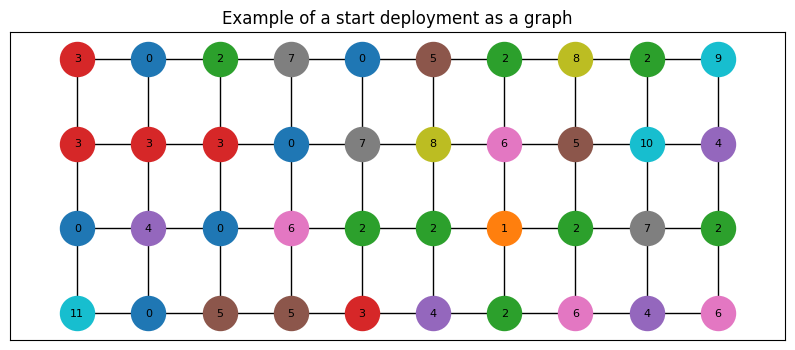

<Figure size 640x480 with 0 Axes>

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Generate a 4x10 grid graph
G = nx.grid_2d_graph(4, 10)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 4))
ax = plt.gca()

# Generate node positions for a 4x10 grid
pos = {(x, y): (y, -x) for x in range(4) for y in range(10)}

one_hot_features = np.argmax(positions[0], axis=1).reshape(4, 10, order='F')

# Iterate over the nodes and assign labels and colors
for (x, y) in G.nodes():
    # Find the index of the active feature
    active_feature_index = one_hot_features[x, y]

    # Assign label and color based on the active feature index
    label = str(active_feature_index)
    color = plt.cm.tab10(active_feature_index)  # Use a color map for coloring nodes

    # Draw the node with the assigned label and color
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[(x, y)], node_color=[color], node_size=600, ax=ax)
    nx.draw_networkx_labels(G, pos=pos, labels={(x, y): label}, font_color='black', font_size=8, ax=ax)

# Draw the edges of the graph
nx.draw_networkx_edges(G, pos=pos, ax=ax)

# Set plot title
plt.title('Example of a start deployment as a graph')

# Show the plot
plt.show()
plt.savefig('grid_graph.png')

In [16]:
def threshold_function(x):
    return (x > 0).float() * 2 - 1  # Convert True/False to 1/-1 and float to convert to float tensor

# Example usage:
values = torch.tensor([0.5, -0.3, 0.1, -0.8])
result = threshold_function(values)
print(result)


tensor([ 1., -1.,  1., -1.])


In [17]:
a = torch.randn(4)
a
torch.clamp(a, min=-0.5, max=0.5)

min = torch.linspace(-1, 1, steps=4)
torch.clamp(a, min=min)

tensor([-0.5630, -0.3333,  0.5236,  1.0000])

In [18]:
x

3

In [19]:
torch.sum(x * (torch.ones(40) / 40))

tensor(3.)

In [20]:
import torch
import torch.nn as nn

class WeightedMeanLayer(nn.Module):
    def __init__(self, input_dim):
        super(WeightedMeanLayer, self).__init__()
        self.weights = nn.Parameter(torch.ones(input_dim) / input_dim)  # Learnable weights

    def forward(self, x):
        weighted_sum = torch.sum(x * self.weights.unsqueeze(0), dim=1)  # Element-wise multiplication and sum along dim 1
        weighted_mean = weighted_sum / x.size(1)  # Divide by length of x
        return weighted_mean


In [21]:
torch.tensor(torch.ones(40) / 40).clone().detach().requires_grad_(True)

<ipython-input-21-6351a0cfd94a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(torch.ones(40) / 40).clone().detach().requires_grad_(True)


tensor([0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250], requires_grad=True)

In [22]:
x

3

In [23]:
import torch
import torch.nn as nn

class WeightedSumLayer(nn.Module):
    def __init__(self, input_dim):
        super(WeightedSumLayer, self).__init__()
        self.weights = nn.Parameter(torch.ones(input_dim) / input_dim)  # Set requires_grad to True

    def forward(self, x):
        weights = self.weights.unsqueeze(0)
        weighted_sum = torch.sum(torch.matmul(x, weights))  # Element-wise multiplication and sum
        return weighted_sum.unsqueeze(0)



In [24]:
from torch_geometric.nn import SAGPooling
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv, SAGEConv
from torch_geometric.nn import global_mean_pool

class SimpleGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim)
        self.linear2 = nn.Linear(input_dim, input_dim)
        self.linear3 = nn.Linear(input_dim, input_dim)
        self.linear4 = nn.Linear(input_dim, 1)
        self.linear5 = nn.Linear(1,1)
        self.conv1 = GCNConv(input_dim, input_dim)
        self.conv2 = GCNConv(input_dim, input_dim)
        self.conv3 = GCNConv(input_dim, input_dim)
        self.conv4 = GCNConv(input_dim, 1)
        #self.sagpool1 = SAGPooling(12, ratio=0.75) #use global pooling not hierarchical pooling method from the paper as fewer overall nodes in graph
        #self.sagpool2 = SAGPooling(12, ratio=0.66()
        #self.sagpool3 = SAGPooling(12, ratio=0.5)
        #self.sagpool4 = SAGPooling(12, ratio=0.5)
        self.tanh = nn.Tanh()
        self.WeightedMean = WeightedMeanLayer(40)
        self.weightedsum = WeightedSumLayer(40)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.tanh(x)
        x = F.dropout(x, p=0.1, training=self.training)

        x = self.conv3(x, edge_index)
        x = self.tanh(x)
        x = F.dropout(x, p=0.1, training=self.training)

        x = self.conv4(x, edge_index)
        x = self.tanh(x)
        x = F.dropout(x, p=0.1, training=self.training)
        #x = self.weightedsum(x)
        x = torch.sum(x)
        #x = self.tanh(x)

        #x = self.conv3(x, edge_index)
        #x = self.tanh(x)
        #x = F.dropout(x, p=0.1, training=self.training)
        #x = self.linear1(x)
        #x = self.tanh(x)  # Apply tanh activation
        #x = F.dropout(x, p=0.1, training=self.training)

        #x = self.conv1(x, edge_index)
        #x = self.sagpool1(x, edge_index=edge_index1)[0]# attention opperation
        #x = F.relu(x)
        #x = self.linear2(x)

        #x = self.sagpool2(x, edge_index=edge_index2)[0]# attention opperation


        #x = self.linear3(x)
        #x = self.sagpool3(x, edge_index3)[0]# attention opperation

        return x

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define train and test set
matches_loader_12_features_training
matches_loader_12_features_test
#define record keeping
batch_loss = 0
epoch_losses =[]
batch_losses=[]
#2.Instantiate the Model
input_size = 12  # Assuming each node has 12 features
hidden_channels = 40

model = SimpleGNN(input_size, hidden_channels,1).to(device)


#3.Define Loss Function and Optimizer
#criterion = nn.HingeEmbeddingLoss(margin=1)
criterion = nn.MarginRankingLoss(margin=1)
optimizer = Adam(model.parameters(), lr=0.001)


#4.Training Loop

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    start_epoch_time = time.time() # Record start time of epoch

    for batch_idx, batch in enumerate(matches_loader_12_features_training):
        start_batch_time = time.time() # Record start time of batch
        data_idx = 0
        batch_output = torch.tensor([]).to(device)
        batch_y = []
        total_batch_loss = 0

        for data in range(len(batch)):
            optimizer.zero_grad()

            x, y, edge_index = batch[data_idx].x.float().to(device), batch[data_idx].y.to(device), batch[data_idx].edge_index.to(device)
            output = model(x, edge_index)
            if batch_output.numel() == 0:
                batch_output = output.unsqueeze(0)
            else:
                batch_output = torch.cat((batch_output, output.unsqueeze(0)), dim=0)
            batch_y.append(y)
            data_idx += 1
        loss = criterion(batch_output, torch.tensor(batch_y).to(device))
        loss.backward()
        optimizer.step()
        total_batch_loss += loss

        end_batch_time = time.time() # Record end time of batch

        # Calculate average loss for this batch
        avg_batch_loss = total_batch_loss
        batch_losses.append(avg_batch_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(matches_loader_12_features_training)}], "
              f"Time: {end_batch_time - start_batch_time:.4f} sec, Avg Batch Loss: {avg_batch_loss:.6f}")

    end_epoch_time = time.time() # Record end time of epoch
    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(avg_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Epoch Loss: {avg_epoch_loss:.6f}, "
          f"Epoch Time: {end_epoch_time - start_epoch_time:.4f} sec")


TypeError: MarginRankingLoss.forward() missing 1 required positional argument: 'target'

In [29]:
batch.x, batch.edge_index

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([[    0,     0,     1,  ..., 17998, 17999, 17999],
         [   10,     1,    11,  ..., 17999, 17989, 17998]]))

In [ ]:
batch_output

In [ ]:
batch_output, batch.y

In [ ]:
sum(batch_losses)

for i, batch in enumerate(matches_loader_12_features_training):
  if i ==46:
    print(torch.mean(batch.y))

In [ ]:
epoch_losses

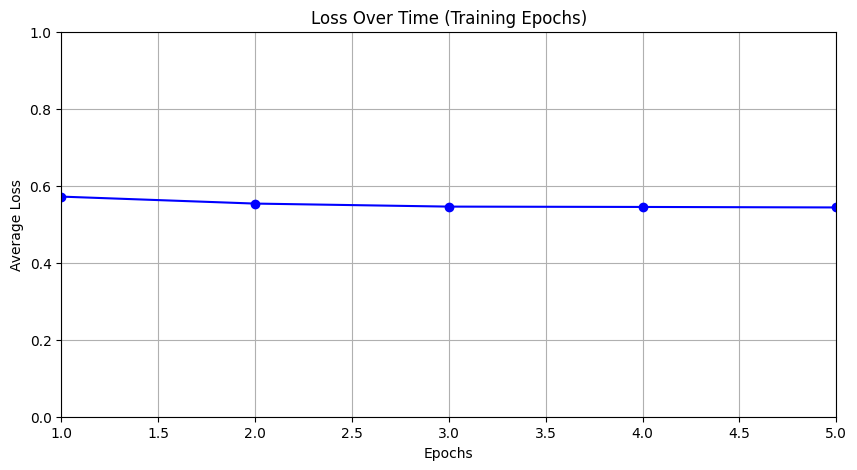

In [33]:
import matplotlib.pyplot as plt


#remove gradients from tensor list
ep_loss_list = []
for loss in epoch_losses:
  ep_loss_list.append(loss.cpu().detach().numpy())

# Loss Over Time (Training Epochs)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), ep_loss_list, marker='o', color='b')
plt.title('Loss Over Time (Training Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.grid(True)
plt.xlim(1, num_epochs)  # Set x limits
plt.ylim(0, 1)  # Set y limits
plt.show()


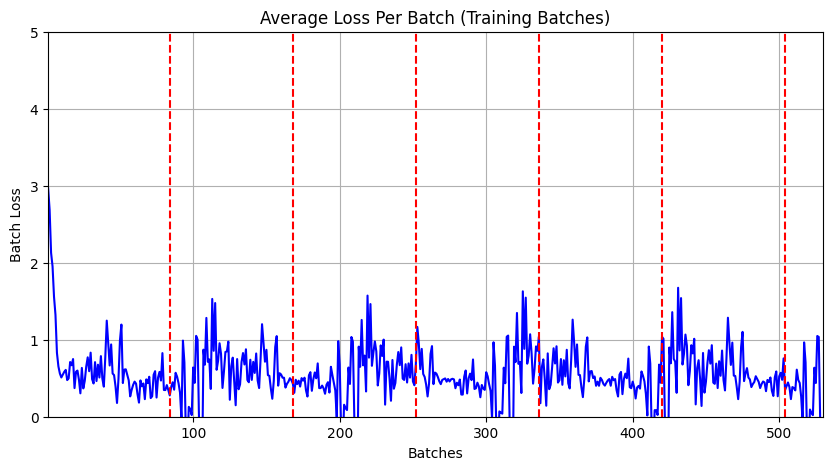

In [34]:
#remove gradients from tensor list
batch_loss_list = []
for loss in batch_losses:
  batch_loss_list.append(loss.cpu().detach().numpy())



# Loss Per Batch (Training Batches)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(batch_loss_list)+1), batch_loss_list, color='b')
plt.title('Average Loss Per Batch (Training Batches)')
plt.xlabel('Batches')
plt.ylabel('Batch Loss')
plt.grid(True)
plt.xlim(1, len(batch_loss_list))  # Set x limits
plt.ylim(0, 5)  # Set y limits

for batch_idx in range(1, len(batch_loss_list)+1):
    if batch_idx % 84 == 0:
        plt.axvline(x=batch_idx, color='r', linestyle='--')

plt.show()


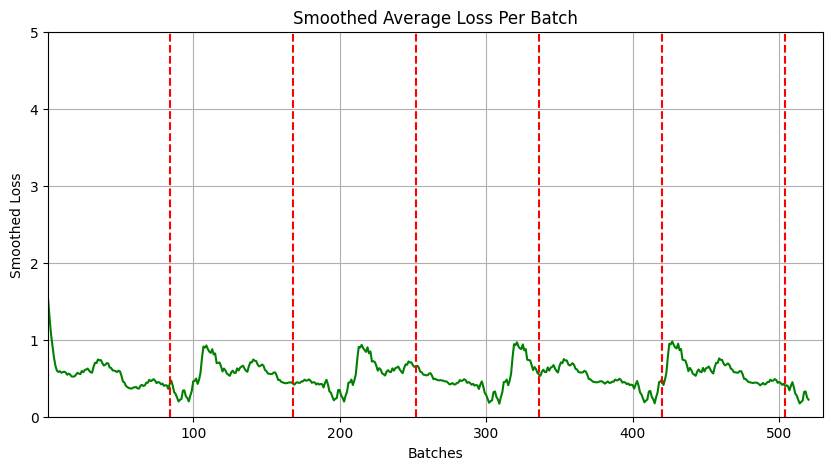

In [46]:
# Smoothed Loss Per Batch
smoothed_losses = [sum(batch_loss_list[i:i+10])/10 for i in range(len(batch_loss_list)-10)]
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(smoothed_losses)+1), smoothed_losses, color='g')
plt.title('Smoothed Average Loss Per Batch')
plt.xlabel('Batches')
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.xlim(1, len(batch_loss_list))  # Set x limits
plt.ylim(0, 5)  # Set y limits
for batch_idx in range(1, len(batch_loss_list)+1):
    if batch_idx % 84 == 0:
        plt.axvline(x=batch_idx, color='r', linestyle='--')

plt.show()

In [ ]:
model.weightedsum.weights

In [ ]:
len(model.weightedsum.weights.detach().numpy())
weights_reshaped

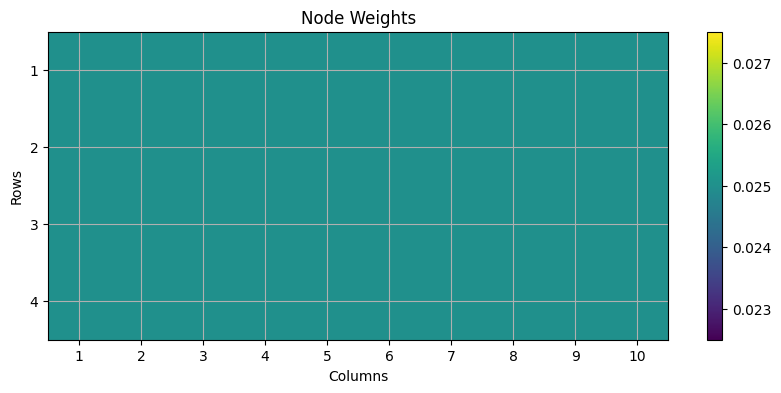

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming you have already instantiated your model and trained it
# model = SimpleGNN(input_size, hidden_channels, 1)
# (train your model...)

# Get the weights from the WeightedSumLayer
weights = model.weightedsum.weights.cpu().detach().numpy()

# Reshape the weights into a 4x10 matrix
weights_reshaped = weights.reshape((4, 10))

# Create the heatmap
plt.figure(figsize=(10, 4))
plt.imshow(weights_reshaped, cmap='viridis', aspect='auto')

# Add title and labels
plt.title('Node Weights')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Add colorbar
plt.colorbar()
plt.grid(True)
plt.xticks(np.arange(10), np.arange(1, 11))  # Set x-axis ticks and labels
plt.yticks(np.arange(4), np.arange(1, 5))    # Set y-axis ticks and labels


# Show the plot
plt.show()


In [ ]:
##used to find batch sizes


def find_divisors(n):
    divisors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            divisors.append(i)
            if i != n // i:
                divisors.append(n // i)
    return divisors

divisors = find_divisors(99132)
divisors.sort()
print("Divisors of", number, ":", divisors)


In [ ]:
# 5. Evaluation
"""MSE calculation"""
#set to model eval mode
model.eval()

#record keeping
correct = 0
total_loss = 0
total = 0
total_batches = len(matches_loader_12_features_test)
average_MSE = 0
average_MSE_list = []
total_MSE_avg = []
total_MSE = 0


start_time = time.time()  #record start time

with torch.no_grad():
    for batch_idx, batch in enumerate(matches_loader_12_features_test):
        iteration = 0  # index for element in batch
        batch_correct = 0
        batch_total = 0
        batch_error = 0
        for data in range(len(batch)):
            x, y, edge_index = batch[iteration].x.float(), batch[iteration].y.float(), batch[iteration].edge_index  # Extract node features, edge index, and target labels

            output = model(x, edge_index)
            total_loss += criterion(output, y).item()
            error = (y-output)**2
            batch_error += error
            batch_total += 1
            total += 1
        total_MSE += batch_error
        avg_batch_MSE = batch_error / batch_total
        average_MSE_list.append(avg_batch_MSE)

        print(f'Batch {batch_idx + 1}/{total_batches}, MSE: {avg_batch_MSE.item():.2f}')

# Compute overall MSE
MSE_avg = sum(average_MSE_list) / 21 #21 is number of batches in test set
end_time = time.time()  # Record end time
total_time = end_time - start_time
print(f'Total Time taken: {total_time:.2f} seconds')
print(f'Validation MSE: {float(total_MSE):.2f}')
print(f'Average MSE per Batch: {MSE_avg.float().item():.2f}')



In [ ]:
batch

In [ ]:
# 5. Evaluation set to accuracy calculation instead of MSE
"""Accuracy calculation"""
#set to model eval mode
model.eval()

#record keeping
correct = 0
total_loss = 0
total = 0
total_batches = len(matches_loader_12_features_test)
average_MSE = 0
batch_accuracy_list = []
total_MSE_avg = []
total_correct = 0
accuracy = 0

start_time = time.time()  #record start time

with torch.no_grad():
    for batch_idx, batch in enumerate(matches_loader_12_features_test):
        iteration = -1  # index for element in batch
        batch_total = 0
        batch_accuracy = 0
        correct = 0
        for data in range(len(batch)):
            iteration+=1
            x, y, edge_index = batch[iteration].x.float(), batch[iteration].y.float(), batch[iteration].edge_index  # Extract node features, edge index, and target labels

            output = model(x, edge_index)
            total_loss += criterion(output, y).item()


            if (output.float()>=0) and y==1:
              correct += 1
            elif (output.float()<=0) and y==-1:
              correct += 1
            else:
              correct += 0


            batch_total += 1
            total += 1
        batch_accuracy = correct / batch_total
        batch_accuracy_list.append(batch_accuracy)
        total_correct += correct
        print(f'Batch {batch_idx + 1}/{total_batches}, Accuracy: {batch_accuracy:.2f}')

# Compute overall accuracy
accuracy_avg = total_correct / len(matches_loader_12_features_test.dataset) #21 is number of batches in test set
end_time = time.time()  # Record end time
total_time = end_time - start_time
print(f'Total Time taken: {total_time:.2f} seconds')
print(f'Validation correct predictions: {float(total_correct):.2f}')
print(f'Average accuracy per batch: {accuracy_avg:.2f}')



In [ ]:
Average accuracy per batch: 0.51

In [ ]:
if (output.float()>=0) and y==1:
  correct += 1
elif (output.float()<=0) and y==-1:
  correct += 1
else:
  correct += 0

In [ ]:
correct,y

In [ ]:
(output.float()>=0) and y==1

In [ ]:
output
if (1>=0):
  correct += 1
else:
  correct += 0

In [ ]:
 if (output.float()>=0) and y==1:
  print(output,y)
elif (output.float()<=0) and y==-1:
  print(output,y)


In [ ]:
output, y

In [ ]:
l = 0
for i in matches_loader_12_features_test:
  l +=1
  print(l)

In [ ]:
output,y,criterion(output, y).item(),
batch_correct += (error == 0).int()
batch_correct

In [ ]:
(error==0).int()

In [ ]:
error, total

In [ ]:
output = model(x, edge_index)
output

In [ ]:
output, y

In [ ]:
criterion(output, y).item()

In [ ]:
batch_output, batch.y

In [ ]:
train_losses#0.69

In [ ]:
model

In [ ]:
# 5. Evaluation
model.eval()
total_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for data in val_dataset:
        x, edge_index, y = data.x.float(), data.edge_index, data.y  # Extract node features, edge index, and target labels

        # Reshape node features x to (batch_size * num_nodes, num_features)
        #x = x.view(-1, x.size(-1))

        output = model(x, edge_index)
        output = output.squeeze(0).squeeze(0)
        total_loss += criterion(output, y).item()
        predicted = torch.argmax(output)
        correct += (predicted == y).sum().item()
        total += 1

# Compute accuracy
accuracy = correct / total
print(f'Validation Accuracy: {accuracy}')

In [ ]:
import torch
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through RNN
        out, _ = self.rnn(x, h0)

        # Extract the output of the last time step
        out = out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)

        # Sigmoid activation for binary classification
        out = self.sigmoid(out)

        return out


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


def custom_collate(batch):
    # Extract features (x) and labels (y) from the Data objects in the batch
    xs = [data.x for data in batch]
    ys = [data.y for data in batch]

    # Stack the features and labels into tensors
    x_batch = torch.stack(xs)
    y_batch = torch.stack(ys)

    return x_batch, y_batch


# Define hyperparameters
input_size = 480  # Number of features for each node
hidden_size = 64  # Hidden size of the RNN
num_layers = 1  # Number of RNN layers
output_size = 1  # Output size (binary classification)

# Instantiate the RNNClassifier model
model = RNNClassifier(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming you have already split your dataset into train and test sets
#test_dataset = MatchesDataset(test_data)    # Create MatchesDataset instance with your test data

# Create DataLoader objects for batching and shuffling your dataset
val = int(len(matches_dataset) * 0.8)  # Convert val to an integer
train_dataset, val_dataset = matches_dataset[:val], matches_dataset[val:]

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=custom_collate,shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=64, collate_fn=custom_collate,shuffle=False)

# Training loop
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    batch_num = -1
    for batch in train_loader:
        batch_num +=1
        inputs, labels = batch[0], batch[1]  # Extract input features and labels from batch
        inputs = inputs.unsqueeze(0).float()
        inputs = inputs.permute(1, 0, 2)  # Convert inputs to float tensor if needed
        labels = labels.float()  # Convert labels to float tensor if needed

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the running loss
        running_loss += loss.item() * inputs.size(0)

    # Print average loss for the epoch
    epoch_loss = running_loss / len(matches_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
list_output = []

# Validation loop (optional)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    batchnum = -1
    for batch in test_loader:
        batchnum += 1
        inputs, labels = batch[0] , batch[1]  # Extract input features and labels from batch
        inputs = inputs.unsqueeze(0).float()
        print(inputs.shape)
        inputs = inputs.permute(1, 0, 2)  # Convert inputs to float tensor if needed
        labels = labels.float()  # Convert labels to float tensor if needed

        # Forward pass
        outputs = model(inputs)
        list_output.append(outputs)

        # Convert outputs to binary predictions (0 or 1)
        predictions = list_output[batchnum]




In [ ]:
for batch in DataLoader(train_dataset, batch_size=64, collate_fn=custom_collate,shuffle=False):
   print(len(batch[0]))

In [ ]:
batch

In [ ]:
list_output[0]-labels

In [ ]:
labels

In [ ]:
inputs.shape

In [ ]:
batch[0].shape

In [ ]:
 batch[0][0].view(-1)

In [ ]:
batch[1]

In [ ]:
len(train_loader)*64

In [ ]:
#2nd phase include creation of own data with minor changes and check how the model responds to it